In [0]:
#%run ./init

INFO: Image loaded successfully.


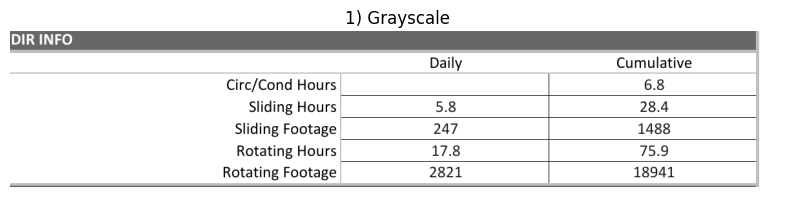

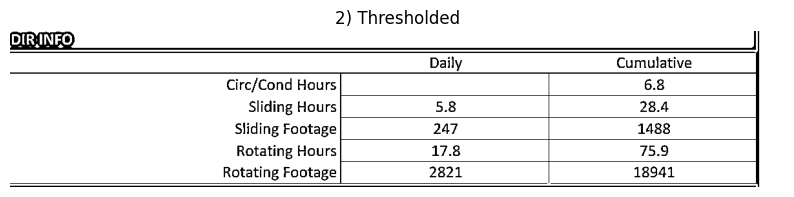

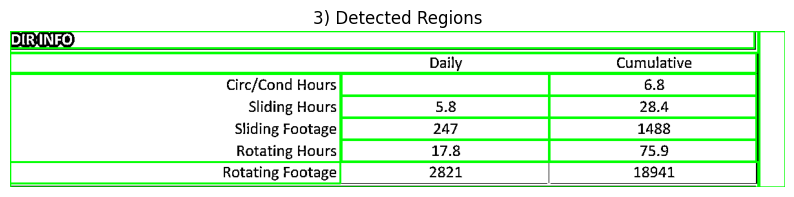

INFO: OCR Box 0: DIR INFO
INFO: OCR Box 1: DIR INFO
INFO: OCR Box 2: [BLANK]
INFO: OCR Box 3: Daily Cumulative
INFO: OCR Box 4: Circ/Cond Hours
Sliding Hours
Sliding Footage
Rotating Hours
Rotating Footage
INFO: OCR Box 5: [BLANK]
INFO: OCR Box 6: 6.8
INFO: OCR Box 7: 5.8
INFO: OCR Box 8: 28.4
INFO: OCR Box 9: 247
INFO: OCR Box 10: 1488
INFO: OCR Box 11: 17.8
INFO: OCR Box 12: 75.9
INFO: OCR Box 13: Rotating Footage 2821 18941
INFO: Structured Data: [{'Category': 'Circ/Cond Hours', 'Daily': '', 'Cumulative': '6.8'}, {'Category': 'Sliding Hours', 'Daily': '5.8', 'Cumulative': '28.4'}, {'Category': 'Sliding Footage', 'Daily': '247', 'Cumulative': '1488'}, {'Category': 'Rotating Hours', 'Daily': '17.8', 'Cumulative': '75.9'}, {'Category': 'Rotating Footage', 'Daily': '2821', 'Cumulative': '18941'}]
INFO: Data saved successfully as CSV.
INFO: Data saved successfully in JSON format.
INFO: {
    "DIR INFO": [
        {
            "Category": "Circ/Cond Hours",
            "Daily": "",
     

           Category Daily Cumulative
0   Circ/Cond Hours              6.8
1     Sliding Hours   5.8       28.4
2   Sliding Footage   247       1488
3    Rotating Hours  17.8       75.9
4  Rotating Footage  2821      18941


In [0]:
import os
import re
import cv2
import pytesseract
import numpy as np
import pandas as pd
import logging
import json
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Logger Setup
# ---------------------------------------------------------------------
logger = logging.getLogger("dir_infoExtractor")
logger.setLevel(logging.INFO)
if not logger.handlers:
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
    logger.addHandler(handler)

# ---------------------------------------------------------------------
# Utility: show_image
# ---------------------------------------------------------------------
def show_image(title, img, cmap=None, size=(10,10)):
    plt.figure(figsize=size)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

# ---------------------------------------------------------------------
# safe_read_image
# ---------------------------------------------------------------------
def safe_read_image(img_path):
    """
    Reads an image from a local or DBFS path.
    """
    local_path = img_path.replace("dbfs:", "/dbfs") if img_path.startswith("dbfs:") else img_path
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"File not found: {local_path}")
    img = cv2.imread(local_path)
    if img is None:
        raise ValueError(f"Failed to load image: {local_path}")
    return img

# ---------------------------------------------------------------------
# preprocess_image
# ---------------------------------------------------------------------
def preprocess_image(img, debug=False):
    """
    Converts image to grayscale and applies adaptive thresholding.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if debug:
        show_image("1) Grayscale", gray, cmap="gray")
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 15, 9
    )
    if debug:
        show_image("2) Thresholded", thresh, cmap="gray")
    return thresh

# ---------------------------------------------------------------------
# detect_text_regions
# ---------------------------------------------------------------------
def detect_text_regions(thresh_img, debug=False):
    """
    Detects text regions (bounding boxes) from the thresholded image.
    Only regions larger than 30x15 pixels are kept.
    """
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
    rois.sort(key=lambda b: (b[1], b[0]))  # top->bottom, then left->right

    if debug:
        debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in rois:
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        show_image("3) Detected Regions", debug_img)
    return rois

# ---------------------------------------------------------------------
# perform_ocr_on_rois
# ---------------------------------------------------------------------
def perform_ocr_on_rois(img, rois, debug=False):
    """
    Performs OCR on each detected text region.
    Returns list of tuples: (x, y, w, h, text).
    """
    results = []
    for i, (x, y, w, h) in enumerate(rois):
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip() or "[BLANK]"
        results.append((x, y, w, h, text))
        if debug:
            logger.info(f"OCR Box {i}: {text}")
    return results

# ---------------------------------------------------------------------
# build_dir_info_dict_from_rois
# ---------------------------------------------------------------------
def build_dir_info_dict_from_rois(roi_texts):
    """
    Because of the known layout:
      - "Daily Cumulative" is a bounding box
      - The next bounding box has multiple lines for categories
      - Then each subsequent bounding box has the daily/cumulative values in order
      - The last bounding box merges "Rotating Footage" with its daily/cumulative

    We'll parse them in a fixed sequence:
      1) Find the bounding box that has "Daily Cumulative".
      2) The next bounding box has 5 lines (the categories).
      3) Then read 8 bounding boxes for the first 4 categories (2 each: daily/cumulative).
      4) Finally parse the last bounding box that merges the 5th category with daily/cumulative.

    This is tailored to your example layout.
    """
    # Convert (x,y,w,h,text) into a list of just text for convenience
    all_texts = [t[4] for t in roi_texts]

    # 1) Find index of "Daily Cumulative"
    daily_cum_idx = None
    for i, txt in enumerate(all_texts):
        # Lowercase match
        if "daily" in txt.lower() and "cumulative" in txt.lower():
            daily_cum_idx = i
            break

    if daily_cum_idx is None:
        logger.warning("Could not find 'Daily Cumulative' bounding box. Returning empty data.")
        return [], pd.DataFrame()

    # 2) The next bounding box (daily_cum_idx + 1) should have the 5 category lines
    cat_idx = daily_cum_idx + 1
    if cat_idx >= len(all_texts):
        logger.warning("No bounding box found after 'Daily Cumulative'. Returning empty data.")
        return [], pd.DataFrame()

    # Split that bounding box by newline
    categories_box = all_texts[cat_idx]
    lines = [ln.strip() for ln in categories_box.split("\n") if ln.strip()]

    # We expect 5 lines in that bounding box
    #  e.g. ["Circ/Cond Hours", "Sliding Hours", "Sliding Footage", "Rotating Hours", "Rotating Footage"]
    if len(lines) < 5:
        logger.warning(f"Expected 5 category lines, got {len(lines)}: {lines}")

    # 3) Next bounding boxes for the first 4 categories
    # We have:
    #   (cat_idx + 1) -> [BLANK]
    #   (cat_idx + 2) -> 6.8
    #   (cat_idx + 3) -> 5.8
    #   (cat_idx + 4) -> 28.4
    #   (cat_idx + 5) -> 247
    #   (cat_idx + 6) -> 1488
    #   (cat_idx + 7) -> 17.8
    #   (cat_idx + 8) -> 75.9
    #   (cat_idx + 9) -> Rotating Footage 2821 18941

    # We want:
    #   1) Circ/Cond Hours -> daily="", cumulative="6.8"
    #   2) Sliding Hours   -> daily="5.8", cumulative="28.4"
    #   3) Sliding Footage -> daily="247", cumulative="1488"
    #   4) Rotating Hours  -> daily="17.8", cumulative="75.9"
    #   5) Rotating Footage -> daily="2821", cumulative="18941"

    # Let's define the known offset
    # first 4 categories get 2 bounding boxes each
    # The 5th category is in the last bounding box
    # We'll store them in a structured list
    structured_data = []

    # Because lines might be fewer or more, let's do a safe approach:
    # We'll gather them in the order we see them:
    # lines[0] = "Circ/Cond Hours"
    # lines[1] = "Sliding Hours"
    # lines[2] = "Sliding Footage"
    # lines[3] = "Rotating Hours"
    # lines[4] = "Rotating Footage"

    # We'll map them carefully to the bounding boxes:
    # cat_idx+1 -> daily for circ/cond hours
    # cat_idx+2 -> cumulative for circ/cond hours
    # cat_idx+3 -> daily for sliding hours
    # cat_idx+4 -> cumulative for sliding hours
    # cat_idx+5 -> daily for sliding footage
    # cat_idx+6 -> cumulative for sliding footage
    # cat_idx+7 -> daily for rotating hours
    # cat_idx+8 -> cumulative for rotating hours
    # cat_idx+9 -> "Rotating Footage 2821 18941" => parse daily/cumulative

    # We'll define a small helper to fetch text safely
    def safe_get_text(idx):
        if 0 <= idx < len(all_texts):
            return all_texts[idx]
        return ""

    # 4) Parse the first 4 categories
    # We expect exactly 8 bounding boxes for them
    # Indices: cat_idx+1 to cat_idx+8
    # We'll do them in pairs
    for i in range(4):
        cat_name = lines[i] if i < len(lines) else f"Unknown Category {i+1}"
        daily_box = safe_get_text(cat_idx + 1 + (i * 2))   # e.g. cat_idx+1, +3, +5, +7
        cum_box   = safe_get_text(cat_idx + 2 + (i * 2))   # e.g. cat_idx+2, +4, +6, +8

        # For the very first category, we want daily="", cumulative="6.8"
        # But the bounding box #6 is "6.8", and bounding box #5 is "[BLANK]"
        # So daily_box = "[BLANK]", cum_box = "6.8"
        # Perfect.

        structured_data.append({
            "Category": cat_name,
            "Daily": daily_box if daily_box != "[BLANK]" else "",
            "Cumulative": cum_box if cum_box != "[BLANK]" else ""
        })

    # 5) Parse the last category from bounding box cat_idx+9
    # bounding box #14 => "Rotating Footage 2821 18941"
    # We parse the line to get daily/cumulative
    last_box = safe_get_text(cat_idx + 9)
    # This might contain something like: "Rotating Footage 2821 18941"
    # We'll remove "Rotating Footage" from it, then parse the two numbers
    # But let's check lines[4] if it exists
    if len(lines) >= 5:
        last_cat_name = lines[4]
    else:
        last_cat_name = "Rotating Footage"

    # Example: last_box = "Rotating Footage 2821 18941"
    # remove the category from the front:
    remainder = last_box.replace(last_cat_name, "").strip()
    # remainder = "2821 18941"
    tokens = remainder.split()
    if len(tokens) >= 2:
        daily_val = tokens[0]
        cum_val   = tokens[1]
    else:
        # fallback if the box didn't parse
        daily_val = ""
        cum_val   = ""

    structured_data.append({
        "Category": last_cat_name,
        "Daily": daily_val if daily_val != "[BLANK]" else "",
        "Cumulative": cum_val if cum_val != "[BLANK]" else ""
    })

    logger.info(f"Structured Data: {structured_data}")

    # Convert to DataFrame and JSON
    df = pd.DataFrame(structured_data)
    df.to_csv("dir_info_data.csv", index=False)
    logger.info("Data saved successfully as CSV.")

    structured_data_json = df.to_dict(orient='records')
    with open("dir_info_data.json", "w") as json_file:
        json.dump(structured_data_json, json_file, indent=4)
    logger.info("Data saved successfully in JSON format.")

    return structured_data_json, df

# ---------------------------------------------------------------------
# main_dir_info_pipeline
# ---------------------------------------------------------------------
def main_dir_info_pipeline():
    # Path to your image
    dir_info_img_path = "/dbfs/mnt/mini-proj-dd/cropped_sections/page_1_section_5.png"

    try:
        img = safe_read_image(dir_info_img_path)
        logger.info("Image loaded successfully.")
    except Exception as e:
        logger.error(e)
        return

    # 1) Preprocess
    thresh_img = preprocess_image(img, debug=True)
    # 2) Detect bounding boxes
    rois = detect_text_regions(thresh_img, debug=True)
    # 3) OCR
    roi_texts = perform_ocr_on_rois(img, rois, debug=True)
    # 4) Build structured data
    dir_info_list, df = build_dir_info_dict_from_rois(roi_texts)

    # 5) Final Output
    final_output = {"DIR INFO": dir_info_list}
    logger.info(json.dumps(final_output, indent=4))
    print(df)

    # 6) Save results
    output_folder = "/dbfs/mnt/mini-proj-dd/final_dir_info_results"
    os.makedirs(output_folder, exist_ok=True)
    with open(os.path.join(output_folder, "dir_info_data.json"), "w") as f:
        json.dump(final_output, f, indent=4)
    df.to_csv(os.path.join(output_folder, "dir_info_data.csv"), index=False)
    logger.info("Data saved successfully in output folder.")

if __name__ == "__main__":
    main_dir_info_pipeline()


INFO: Image loaded successfully.
INFO:daily_numbersExtractor:Image loaded successfully.


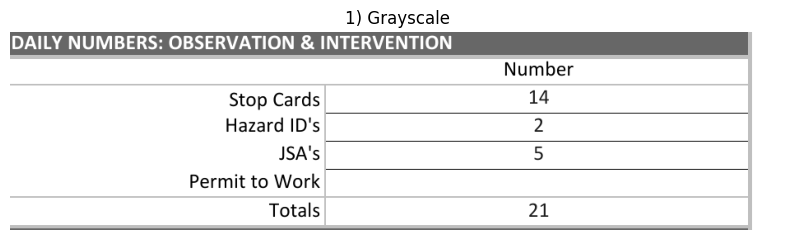

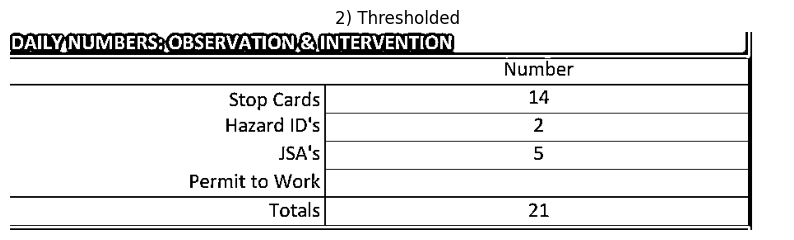

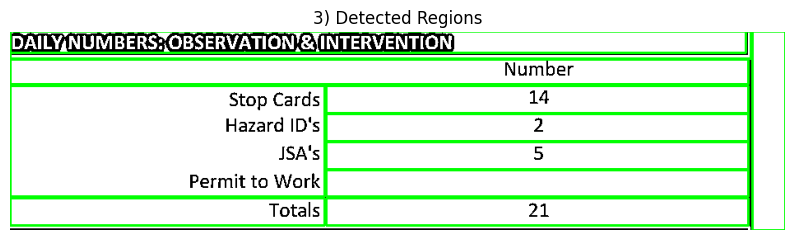

INFO: OCR Box 0: DAILY NUMBERS: OBSERVATION & INTERVENTION
INFO:daily_numbersExtractor:OCR Box 0: DAILY NUMBERS: OBSERVATION & INTERVENTION
INFO: OCR Box 1: DAILY NUMBERS: OBSERVATION & INTERVENTION
INFO:daily_numbersExtractor:OCR Box 1: DAILY NUMBERS: OBSERVATION & INTERVENTION
INFO: OCR Box 2: [BLANK]
INFO:daily_numbersExtractor:OCR Box 2: [BLANK]
INFO: OCR Box 3: Number
INFO:daily_numbersExtractor:OCR Box 3: Number
INFO: OCR Box 4: Stop Cards
Hazard ID's
JSA's

Permit to Work
INFO:daily_numbersExtractor:OCR Box 4: Stop Cards
Hazard ID's
JSA's

Permit to Work
INFO: OCR Box 5: 14
INFO:daily_numbersExtractor:OCR Box 5: 14
INFO: OCR Box 6: 2
INFO:daily_numbersExtractor:OCR Box 6: 2
INFO: OCR Box 7: 5
INFO:daily_numbersExtractor:OCR Box 7: 5
INFO: OCR Box 8: [BLANK]
INFO:daily_numbersExtractor:OCR Box 8: [BLANK]
INFO: OCR Box 9: Totals
INFO:daily_numbersExtractor:OCR Box 9: Totals
INFO: OCR Box 10: 21
INFO:daily_numbersExtractor:OCR Box 10: 21
INFO: Structured Data: [{'Type': 'Stop Cards

             Type Number
0      Stop Cards     14
1     Hazard ID's      2
2           JSA's      5
3  Permit to Work       
4          Totals     21


In [0]:
import os
import re
import cv2
import pytesseract
import numpy as np
import pandas as pd
import logging
import json
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Logger Setup
# ---------------------------------------------------------------------
logger = logging.getLogger("daily_numbersExtractor")
logger.setLevel(logging.INFO)
if not logger.handlers:
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
    logger.addHandler(handler)

# ---------------------------------------------------------------------
# Utility: show_image
# ---------------------------------------------------------------------
def show_image(title, img, cmap=None, size=(10,10)):
    plt.figure(figsize=size)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

# ---------------------------------------------------------------------
# safe_read_image
# ---------------------------------------------------------------------
def safe_read_image(img_path):
    """
    Reads an image from a local or DBFS path.
    """
    local_path = img_path.replace("dbfs:", "/dbfs") if img_path.startswith("dbfs:") else img_path
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"File not found: {local_path}")
    img = cv2.imread(local_path)
    if img is None:
        raise ValueError(f"Failed to load image: {local_path}")
    return img

# ---------------------------------------------------------------------
# preprocess_image
# ---------------------------------------------------------------------
def preprocess_image(img, debug=False):
    """
    Converts image to grayscale and applies adaptive thresholding.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if debug:
        show_image("1) Grayscale", gray, cmap="gray")
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 15, 9
    )
    if debug:
        show_image("2) Thresholded", thresh, cmap="gray")
    return thresh

# ---------------------------------------------------------------------
# detect_text_regions
# ---------------------------------------------------------------------
def detect_text_regions(thresh_img, debug=False):
    """
    Detects text regions (bounding boxes) from the thresholded image.
    Only regions larger than 30x15 pixels are kept.
    """
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
    rois.sort(key=lambda b: (b[1], b[0]))  # top->bottom, then left->right

    if debug:
        debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in rois:
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        show_image("3) Detected Regions", debug_img)
    return rois

# ---------------------------------------------------------------------
# perform_ocr_on_rois
# ---------------------------------------------------------------------
def perform_ocr_on_rois(img, rois, debug=False):
    """
    Performs OCR on each detected text region.
    Returns list of tuples: (x, y, w, h, text).
    """
    results = []
    for i, (x, y, w, h) in enumerate(rois):
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip() or "[BLANK]"
        results.append((x, y, w, h, text))
        if debug:
            logger.info(f"OCR Box {i}: {text}")
    return results

# ---------------------------------------------------------------------
# build_obs_int_data_from_rois
# ---------------------------------------------------------------------

def build_obs_int_data_from_rois(roi_texts):
    """
    Dynamically builds structured data from OCR results for the
    "DAILY NUMBERS: OBSERVATION & INTERVENTION" section.
    
    Processing rules:
      - Skip header texts ("DAILY NUMBERS: OBSERVATION & INTERVENTION" or "Number").
      - If an OCR box has multiple lines, split it into separate type entries.
      - If an OCR box is numeric (or a blank marker like "[BLANK]"),
        assign its value to the earliest record that has no number yet.
      - If no unpaired type exists when a numeric value is found, a new record is created.
      - Finally, any record with an empty "Type" is filtered out.
    
    This approach avoids hard-coding the expected count and ensures that no blank key/value pair is included.
    """
    header_str = "daily numbers: observation & intervention"
    records = []

    # Process each OCR box in order.
    for (_, _, _, _, raw_text) in roi_texts:
        text = raw_text.strip()
        low_text = text.lower()
        
        # Skip header texts and column labels.
        if low_text in [header_str, "number"]:
            continue
        
        # If the text contains newlines, treat each line as a separate type.
        if "\n" in text:
            for line in text.splitlines():
                line = line.strip()
                if not line or line.lower() in [header_str, "number", "[blank]"]:
                    continue
                records.append({"Type": line, "Number": None})
        else:
            # Determine if the text represents a number.
            is_numeric = False
            value = text
            if text == "" or low_text == "[blank]":
                is_numeric = True
                value = ""
            else:
                try:
                    float(text)
                    is_numeric = True
                except ValueError:
                    is_numeric = False

            if is_numeric:
                # Pair the number with the earliest record without a number.
                for rec in records:
                    if rec["Number"] is None:
                        rec["Number"] = value
                        break
                else:
                    # No pending record exists; create one with an empty type.
                    records.append({"Type": "", "Number": value})
            else:
                # Non-numeric text is treated as a type.
                records.append({"Type": text, "Number": None})

    # Clean up: replace any None values with an empty string.
    for rec in records:
        if rec["Number"] is None:
            rec["Number"] = ""

    # Filter out any records where the "Type" is empty.
    records = [rec for rec in records if rec["Type"].strip() != ""]

    # Log the structured data.
    logging.getLogger("daily_numbersExtractor").info(f"Structured Data: {records}")

    # Save the results as CSV and JSON.
    df = pd.DataFrame(records)
    csv_filename = "obs_int_data.csv"
    json_filename = "obs_int_data.json"
    df.to_csv(csv_filename, index=False)
    logging.getLogger("daily_numbersExtractor").info(f"Data saved successfully as CSV: {csv_filename}")

    with open(json_filename, "w") as json_file:
        json.dump(records, json_file, indent=4)
    logging.getLogger("daily_numbersExtractor").info(f"Data saved successfully in JSON format: {json_filename}")

    return records, df


# ---------------------------------------------------------------------
# main_obs_int_pipeline
# ---------------------------------------------------------------------
def main_obs_int_pipeline():
    # Path to your image for the "OBSERVATION & INTERVENTION" section.
    obs_int_img_path = "/dbfs/mnt/mini-proj-dd/cropped_sections/page_1_section_10.png"

    try:
        img = safe_read_image(obs_int_img_path)
        logger.info("Image loaded successfully.")
    except Exception as e:
        logger.error(e)
        return

    # 1) Preprocess the image
    thresh_img = preprocess_image(img, debug=True)
    # 2) Detect bounding boxes
    rois = detect_text_regions(thresh_img, debug=True)
    # 3) Perform OCR on each region
    roi_texts = perform_ocr_on_rois(img, rois, debug=True)
    # 4) Build structured data for Observation & Intervention
    obs_int_list, df = build_obs_int_data_from_rois(roi_texts)

    # 5) Final Output
    final_output = {"DAILY NUMBERS: OBSERVATION & INTERVENTION": obs_int_list}
    logger.info(json.dumps(final_output, indent=4))
    print(df)

    # 6) Save results
    output_folder = "/dbfs/mnt/mini-proj-dd/final_obs_int_results"
    os.makedirs(output_folder, exist_ok=True)
    with open(os.path.join(output_folder, "obs_int_data.json"), "w") as f:
        json.dump(final_output, f, indent=4)
    df.to_csv(os.path.join(output_folder, "obs_int_data.csv"), index=False)
    logger.info("Data saved successfully in output folder.")

if __name__ == "__main__":
    main_obs_int_pipeline()
